<a href="https://colab.research.google.com/github/MirasKaidullayev/NMT/blob/main/Bilingual_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers sentencepiece datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 23.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

/usr/local/lib/python3.10/dist-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [ ]:
uploaded_kazakh = files.upload()

# Get the path to the uploaded Kazakh file
uploaded_kazakh_file_path = next(iter(uploaded_kazakh))

# Read the content of the uploaded Kazakh file
with open(uploaded_kazakh_file_path, 'r', encoding='utf-8') as file:
    kazakh_text = file.read()



uploaded_english = files.upload()

# Get the path to the uploaded English file
uploaded_english_file_path = next(iter(uploaded_english))

# Read the content of the uploaded English file
with open(uploaded_english_file_path, 'r', encoding='utf-8') as file:
    english_text = file.read()

Saving kazakh_text.txt to kazakh_text (1).txt


Saving english_text.txt to english_text (1).txt


In [ ]:
with open('kazakh_text.txt', 'r', encoding='utf-8') as f:
    kazakh_lines = f.readlines()

# Read English text file
with open('english_text.txt', 'r', encoding='utf-8') as f:
    english_lines = f.readlines()

# Zip Kazakh and English lines into tuples
aligned_sentences = list(zip(kazakh_lines, english_lines))

# Print a sample of aligned sentences
for kazakh_sentence, english_sentence in aligned_sentences[:10]:
    print("Kazakh:", kazakh_sentence.strip())
    print("English:", english_sentence.strip())
    print()

Kazakh: 5g ұялы байланыс технологиясы негізінде Заттар интернетінің ақпаратын интерактивті қабылдау Жүйесін әзірлеу
English: Design of Internet of Things Information Interactive Perception System Based on 5G Mobile Communication Technology

Kazakh: Сучжоу өнеркәсіптік технологиялар кәсіби институты, Сучжоу, Цзянсу, 215104, Қытай
English: Suzhou Vocational Institute of Industrial Technology, Suzhou, Jiangsu, 215104, China

Kazakh: Түйінді сөздер: 5g ұялы байланысы, Заттар интернеті, уақытты дамыту
English: Keywords: 5G Mobile Communication, Internet of Things, Development of the Times

Kazakh: Аннотация: соңғы жылдары интернет-технологиялар мен компьютерлік технологиялардың үздіксіз реформалануы мен ілгерілеуіне байланысты ұялы байланыс технологиялары да кеңінен дамыды.
English: Abstract: In recent years, with the continuous reform and progress of Internet technology and computer technology, mobile communication technology also has a cross era development.

Kazakh: Қазір адамзат қоғамы 

In [ ]:
print(len(kazakh_lines))
print(len(english_lines))

2020
2020


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define Tokenizers for Kazakh and English
kazakh_tokenizer = Tokenizer(filters='', oov_token='<unk>')
english_tokenizer = Tokenizer(filters='', oov_token='<unk>')

# Fit Tokenizers on aligned sentences
aligned_sentences = list(zip(kazakh_lines, english_lines))
kazakh_sentences, english_sentences = zip(*aligned_sentences)
kazakh_tokenizer.fit_on_texts(kazakh_sentences)
english_tokenizer.fit_on_texts(english_sentences)

# Convert sentences to sequences of integers
kazakh_sequences = kazakh_tokenizer.texts_to_sequences(kazakh_sentences)
english_sequences = english_tokenizer.texts_to_sequences(english_sentences)

# Pad sequences to uniform length
max_kazakh_length = max(len(seq) for seq in kazakh_sequences)
max_english_length = max(len(seq) for seq in english_sequences)

padded_kazakh_sequences = pad_sequences(kazakh_sequences, maxlen=max_kazakh_length, padding='post')
padded_english_sequences = pad_sequences(english_sequences, maxlen=max_english_length, padding='post')

# Convert sequences to numpy arrays
encoder_input_data = np.array(padded_kazakh_sequences)
decoder_input_data = np.array(padded_english_sequences[:, :-1])  # Remove last token from target sequences
decoder_target_data = np.array(padded_english_sequences[:, 1:])   # Shift target sequences by one timestep

# Get vocabulary sizes
kazakh_vocab_size = len(kazakh_tokenizer.word_index) + 1
english_vocab_size = len(english_tokenizer.word_index) + 1

# Print some information about the preprocessed data
print("Encoder input shape:", encoder_input_data.shape)
print("Decoder input shape:", decoder_input_data.shape)
print("Decoder target shape:", decoder_target_data.shape)
print("Kazakh vocabulary size:", kazakh_vocab_size)
print("English vocabulary size:", english_vocab_size)

Encoder input shape: (2020, 77)
Decoder input shape: (2020, 91)
Decoder target shape: (2020, 91)
Kazakh vocabulary size: 10581
English vocabulary size: 8409


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string

filter_chars = string.digits + string.punctuation + '«»—…'

kazakh_tokenizer = Tokenizer(filters=filter_chars, oov_token='<unk>')
english_tokenizer = Tokenizer(filters=filter_chars, oov_token='<unk>')


aligned_sentences = list(zip(kazakh_lines, english_lines))
kazakh_sentences, english_sentences = zip(*aligned_sentences)
kazakh_tokenizer.fit_on_texts(kazakh_sentences)
english_tokenizer.fit_on_texts(english_sentences)


kazakh_sequences = kazakh_tokenizer.texts_to_sequences(kazakh_sentences)
english_sequences = english_tokenizer.texts_to_sequences(english_sentences)


max_kazakh_length = max(len(seq) for seq in kazakh_sequences)
max_english_length = max(len(seq) for seq in english_sequences)

padded_kazakh_sequences = pad_sequences(kazakh_sequences, maxlen=max_kazakh_length, padding='post')
padded_english_sequences = pad_sequences(english_sequences, maxlen=max_english_length, padding='post')


encoder_input_data = np.array(padded_kazakh_sequences)
decoder_input_data = np.array(padded_english_sequences[:, :-1])  # Remove last token from target sequences
decoder_target_data = np.array(padded_english_sequences[:, 1:])   # Shift target sequences by one timestep


kazakh_vocab_size = len(kazakh_tokenizer.word_index) + 1
english_vocab_size = len(english_tokenizer.word_index) + 1

# Print some information about the preprocessed data
print("Encoder input shape:", encoder_input_data.shape)
print("Decoder input shape:", decoder_input_data.shape)
print("Decoder target shape:", decoder_target_data.shape)
print("Kazakh vocabulary size:", kazakh_vocab_size)
print("English vocabulary size:", english_vocab_size)

Epoch 1/10
26/26 [==============================] - 125s 5s/step - loss: 5.2123 - accuracy: 0.7365 - val_loss: 1.8815 - val_accuracy: 0.8094
Epoch 2/10
26/26 [==============================] - 100s 4s/step - loss: 2.0369 - accuracy: 0.7670 - val_loss: 1.6997 - val_accuracy: 0.8094
Epoch 3/10
26/26 [==============================] - 109s 4s/step - loss: 1.9032 - accuracy: 0.7670 - val_loss: 1.6817 - val_accuracy: 0.8094
Epoch 4/10
26/26 [==============================] - 106s 4s/step - loss: 2.3895 - accuracy: 0.7415 - val_loss: 1.8811 - val_accuracy: 0.8098
Epoch 5/10
26/26 [==============================] - 106s 4s/step - loss: 1.9592 - accuracy: 0.7676 - val_loss: 1.6221 - val_accuracy: 0.8101
Epoch 6/10
26/26 [==============================] - 108s 4s/step - loss: 1.7713 - accuracy: 0.7693 - val_loss: 1.5625 - val_accuracy: 0.8120
Epoch 7/10
26/26 [==============================] - 107s 4s/step - loss: 1.7043 - accuracy: 0.7748 - val_loss: 1.5462 - val_accuracy: 0.8130
Epoch 8/10
26

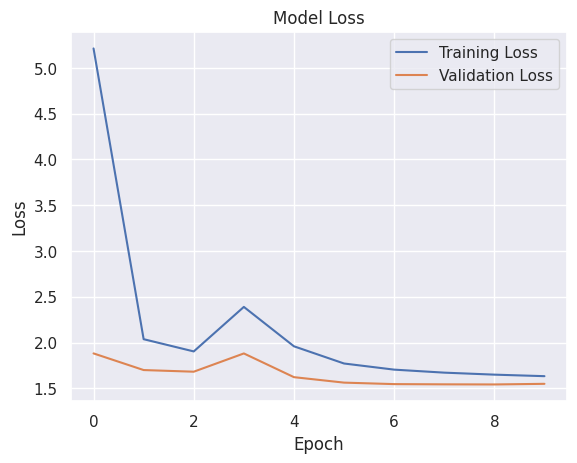

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

# Define the NMT model
def create_nmt_model(kazakh_vocab_size, english_vocab_size, latent_dim):
    # Encoder
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_dim=kazakh_vocab_size, output_dim=latent_dim)(encoder_inputs)
    encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(input_dim=english_vocab_size, output_dim=latent_dim)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(english_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

# Define hyperparameters
latent_dim = 256

# Create and compile the model
model = create_nmt_model(kazakh_vocab_size, english_vocab_size, latent_dim)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=64, epochs=10, validation_split=0.2)

# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
uploaded_kazakh = files.upload()

# Get the path to the uploaded Kazakh file
uploaded_kazakh_file_path = next(iter(uploaded_kazakh))

# Read the content of the uploaded Kazakh file
with open(uploaded_kazakh_file_path, 'r', encoding='utf-8') as file:
    test_kaz = file.read()



uploaded_english = files.upload()

# Get the path to the uploaded English file
uploaded_english_file_path = next(iter(uploaded_english))

# Read the content of the uploaded English file
with open(uploaded_english_file_path, 'r', encoding='utf-8') as file:
    test_eng = file.read()

Saving test_kaz.txt to test_kaz.txt


Saving test_eng.txt to test_eng.txt


In [ ]:
# Read sentences from the test_kaz file and tokenize them
test_kaz_sentences = []
with open('kazakh_text (1).txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Tokenize the sentence and convert it to lowercase
        tokens = line.strip().lower().split()  # You can use a more sophisticated tokenizer if needed
        test_kaz_sentences.append(tokens)

# Print the first few tokenized sentences
for i in range(5):
    print(test_kaz_sentences[i])


['5g', 'ұялы', 'байланыс', 'технологиясы', 'негізінде', 'заттар', 'интернетінің', 'ақпаратын', 'интерактивті', 'қабылдау', 'жүйесін', 'әзірлеу']
['сучжоу', 'өнеркәсіптік', 'технологиялар', 'кәсіби', 'институты,', 'сучжоу,', 'цзянсу,', '215104,', 'қытай']
['түйінді', 'сөздер:', '5g', 'ұялы', 'байланысы,', 'заттар', 'интернеті,', 'уақытты', 'дамыту']
['аннотация:', 'соңғы', 'жылдары', 'интернет-технологиялар', 'мен', 'компьютерлік', 'технологиялардың', 'үздіксіз', 'реформалануы', 'мен', 'ілгерілеуіне', 'байланысты', 'ұялы', 'байланыс', 'технологиялары', 'да', 'кеңінен', 'дамыды.']
['қазір', 'адамзат', 'қоғамы', '5g', 'мобильді', 'ақпарат', 'дәуіріне', 'еніп,', 'заттар', 'интернеті', 'де', 'пайда', 'болды.']


In [ ]:
# Read sentences from the test_eng file and tokenize them
test_eng_sentences = []
with open('english_text (1).txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Tokenize the sentence and convert it to lowercase
        tokens = line.strip().lower().split()  # You can use a more sophisticated tokenizer if needed
        test_eng_sentences.append(tokens)

# Print the first few tokenized sentences
for i in range(5):
    print(test_eng_sentences[i])


['design', 'of', 'internet', 'of', 'things', 'information', 'interactive', 'perception', 'system', 'based', 'on', '5g', 'mobile', 'communication', 'technology']
['suzhou', 'vocational', 'institute', 'of', 'industrial', 'technology,', 'suzhou,', 'jiangsu,', '215104,', 'china']
['keywords:', '5g', 'mobile', 'communication,', 'internet', 'of', 'things,', 'development', 'of', 'the', 'times']
['abstract:', 'in', 'recent', 'years,', 'with', 'the', 'continuous', 'reform', 'and', 'progress', 'of', 'internet', 'technology', 'and', 'computer', 'technology,', 'mobile', 'communication', 'technology', 'also', 'has', 'a', 'cross', 'era', 'development.']
['now,', 'human', 'society', 'is', 'stepping', 'into', 'the', '5g', 'mobile', 'information', 'age,', 'and', 'the', 'internet', 'of', 'things', 'is', 'also', 'born.']


In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')

# Tokenize the Kazakh text into sentences
kazakh_sentences = sent_tokenize(kazakh_text)

# Tokenize each sentence into words
preprocessed_kazakh_text = []
for sentence in kazakh_sentences:
    # Tokenize the sentence into words
    words = word_tokenize(sentence)
    # Convert words to lowercase
    words = [word.lower() for word in words]
    # Append the preprocessed words to the preprocessed Kazakh text
    preprocessed_kazakh_text.append(words)

# Print the first few preprocessed sentences
for i in range(5):
    print(preprocessed_kazakh_text[i])